In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Setup

This code requires downloading the ELS:2002 data from https://nces.ed.gov/surveys/els2002/. Here are instructions for correct setup.

1) Click this link to download the student dataset: https://nces.ed.gov/datalab/files/zip/OnlineCodebook/ELS_2002-12_PETS_v1_0_Student_CSV_Datasets.zip
2) Unzip the file, it should contain a single csv file named `els_02_12_byf3pststu_v1_0.csv`
3) Move this file to the `ELS_data` folder in this project. 

In [5]:
data_file = 'ELS_data/els_02_12_byf3pststu_v1_0.csv'
description_file = 'ELS_data/BYF3PSTSU/descriptions.txt'
labels_file = 'ELS_data/BYF3PSTSU/labels.txt'

In [6]:
# extract data from els_02_12_byf3pststu_v1_0.csv
df = pd.read_csv(data_file)

/var/folders/cx/6_9tlm254dz38yq5qwq7dxfr0000gn/T/ipykernel_10242/2754574438.py:2: DtypeWarning: Columns (1222) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


In [7]:
# dictionary of column names and descriptions
descriptions = {}
with open(description_file) as f:
    for line in f:
        # split into three parts
        key, _, val = line.split(maxsplit=2)
        # if key ends with "WT", don't add
        if key.endswith("WT"):
            continue
        # if key is in filtered_df.columns, add to dictionary
        if key in df.columns:
            descriptions[key] = val

In [8]:
# dictionary of column names and labels
labels = {}
with open(labels_file) as f:
    current_label = f.readline().strip()
    labels[current_label] = {}

    for line in f:
        # if line does not contain an equal sign, it is a label
        if "=" not in line:
            current_label = line.strip()
            labels[current_label] = {}
        # if line contains an equal sign, it is category value
        else:
            key, val = line.split("= \"")
            
            # remove trailing whitespace
            val = val.strip()
            key = key.strip()

            # remove quotation marks from val
            val = val.replace('"', '')

            # add to dictionary
            labels[current_label][key] = val

# Constructing Outcome Variables

In [9]:
# remove columns containing only -5 from df (suppressed data)
df = df.loc[:, (df != -5).any(axis=0)]
# remove rows with negative F3TZYR1GPA
df = df[df["F3TZYR1GPA"] >= 0]
# add new outcome variable -- GPA >= 3.0
df["GPA_3"] = np.where(df["F3TZYR1GPA"] >= 3.0, 1, 0)
descriptions["GPA_3"] = "GPA >= 3.0"

outcomes = ["GPA_3", "F3TZYR1GPA"]
df.head()


,STU_ID,STRAT_ID,PSU,F1SCH_ID,F1UNIV1,F1UNIV2A,F1UNIV2B,F2UNIV_P,F3UNIV,F3UNIVG10,...,BYF10E,BYF10F,BYF10G,BYF10H,BYF10I,BYF10J,BYF10K,BYF10L,BYF10M,GPA_3
1,101102,101,1,1011,101,1,1,101,1111,11111,...,1,1,1,1,1,1,1,0,0,1
2,101104,101,1,1011,101,1,1,101,1111,11111,...,1,1,1,1,1,1,1,0,0,0
3,101105,101,1,1011,101,1,1,101,1111,11111,...,1,1,1,1,1,1,1,0,0,0
4,101106,101,1,1011,101,1,1,101,1111,11111,...,1,1,1,1,1,1,1,0,0,1
6,101108,101,1,1011,101,1,1,101,1111,11111,...,1,1,1,1,1,1,1,0,0,0


# Selecting Covariates

In [10]:
# remove students without birth date
df = df[df["F1DOB_P"] > 0]
# new YOB column
df["F1YOB"] = df["F1DOB_P"].astype(str).str[:4].astype(int)
descriptions["F1YOB"] = "Year of birth"

protected_x = ["F1SEX", "F1RACE"]

reduced_dem_x = ["F1SES1QU", "F1FCOMP", "F1MOTHED", "F1OCCUF", "F1YOB"]

reduced_academic_x = ["F1S26F", "F1RGPP2", "F1S31", "F1HIMATH", "F1RTRCC", "F1TXMQU", "F1TXMSTD", "F1TX4MPP"]

reduced_extracurricular_x = ["F1XTRACU", "F1S26B", "F1WRKHRS", "F1S62"]

reduced_features = reduced_dem_x + reduced_academic_x + reduced_extracurricular_x + protected_x

In [11]:
# create a new dataframe with only the columns we want
reduced_feature_df = df[reduced_features + outcomes]

# remove rows with missing data
for f in reduced_features:
    reduced_feature_df = reduced_feature_df[reduced_feature_df[f] >= 0]

print(reduced_feature_df.shape)
reduced_feature_df.head()

(8669, 21)


,F1SES1QU,F1FCOMP,F1MOTHED,F1OCCUF,F1YOB,F1S26F,F1RGPP2,F1S31,F1HIMATH,F1RTRCC,...,F1TXMSTD,F1TX4MPP,F1XTRACU,F1S26B,F1WRKHRS,F1S62,F1SEX,F1RACE,GPA_3,F3TZYR1GPA
1,4,1,5,9,1986,2,4,6,6,1,...,60.64,0.97,2,1,1,1,2,2,1,3.00
2,1,1,2,5,1986,1,4,6,6,4,...,64.26,1.00,2,1,0,1,2,7,0,2.75
3,1,5,2,6,1986,1,4,4,4,2,...,45.59,0.01,1,1,5,0,2,3,0,2.50
4,1,1,1,5,1985,1,4,4,5,2,...,38.79,0.00,0,1,6,1,2,4,1,3.00
6,3,1,6,15,1986,1,2,3,5,2,...,46.15,0.01,0,1,6,0,1,4,0,2.25


In [12]:
non_cat_x = ["F1S62", "F1SEX", "F1RACE", 'F1TXMSTD', 'F1TX4MPP']

# # convert columns not in non_cat_x to one-hot encoding
reduced_oh_feature_df = pd.get_dummies(reduced_feature_df, columns=[f for f in reduced_features if f not in non_cat_x], dtype = int)
print(reduced_oh_feature_df.shape)
reduced_oh_feature_df.head()


(8669, 106)


,F1TXMSTD,F1TX4MPP,F1S62,F1SEX,F1RACE,GPA_3,F3TZYR1GPA,F1SES1QU_1,F1SES1QU_2,F1SES1QU_3,...,F1WRKHRS_0,F1WRKHRS_1,F1WRKHRS_2,F1WRKHRS_3,F1WRKHRS_4,F1WRKHRS_5,F1WRKHRS_6,F1WRKHRS_7,F1WRKHRS_8,F1WRKHRS_9
1,60.64,0.97,1,2,2,1,3.00,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,64.26,1.00,1,2,7,0,2.75,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,45.59,0.01,0,2,3,0,2.50,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,38.79,0.00,1,2,4,1,3.00,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,46.15,0.01,0,1,4,0,2.25,0,0,1,...,0,0,0,0,0,0,1,0,0,0


# Data Makeup

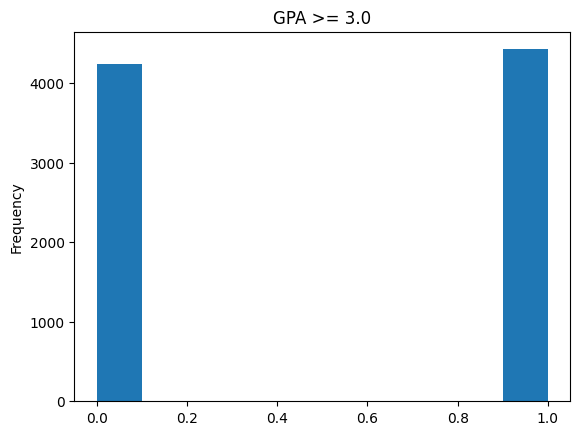

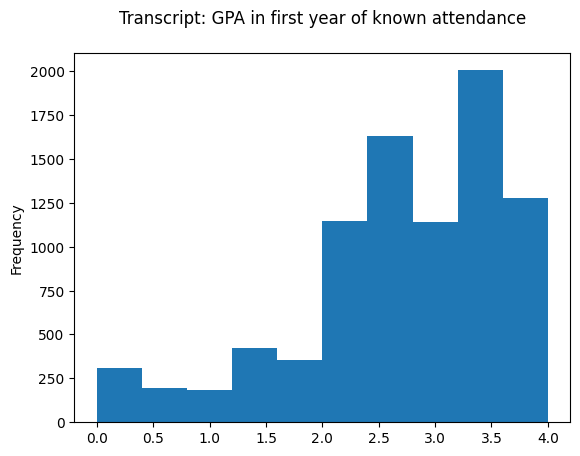

In [13]:
# plot each column in outcomes as a histogram
for outcome in outcomes:
    reduced_feature_df[outcome].plot.hist(title=descriptions[outcome])
    plt.show()
    

# Saving Datasets

In [14]:
# add student id column
reduced_oh_feature_df["id"] = range(len(reduced_oh_feature_df))
print(reduced_oh_feature_df.head())

   F1TXMSTD  F1TX4MPP  F1S62  F1SEX  F1RACE  GPA_3  F3TZYR1GPA  F1SES1QU_1  \
1     60.64      0.97      1      2       2      1        3.00           0   
2     64.26      1.00      1      2       7      0        2.75           1   
3     45.59      0.01      0      2       3      0        2.50           1   
4     38.79      0.00      1      2       4      1        3.00           1   
6     46.15      0.01      0      1       4      0        2.25           0   

   F1SES1QU_2  F1SES1QU_3  ...  F1WRKHRS_1  F1WRKHRS_2  F1WRKHRS_3  \
1           0           0  ...           1           0           0   
2           0           0  ...           0           0           0   
3           0           0  ...           0           0           0   
4           0           0  ...           0           0           0   
6           0           1  ...           0           0           0   

   F1WRKHRS_4  F1WRKHRS_5  F1WRKHRS_6  F1WRKHRS_7  F1WRKHRS_8  F1WRKHRS_9  id  
1           0           0     

In [15]:
# save reduced df
reduced_oh_feature_df.to_csv("cleaned_data.csv", index=False)


# df without gpa == 3
reduced_df_no_gpa_3 = reduced_oh_feature_df[reduced_oh_feature_df["F3TZYR1GPA"] != 3]

# save reduced df_no_gpa_3
reduced_df_no_gpa_3.to_csv("no_gpa_3_cleaned_data.csv", index=False)

In [16]:
print(reduced_df_no_gpa_3.shape)
print(reduced_oh_feature_df.shape)

(7528, 107)
(8669, 107)
